
# Лабаораторная работа №1: Аудио EDA и характеристики сигнала

**Цель:** научиться загружать аудиодатасеты, читать и интерпретировать метаданные, вычислять базовые характеристики аудиосигнала и строить визуализации (waveform, спектр, Mel/Log‑Mel).  
**Формат:** заполнить `TODO`‑ячейки. Ячейки с `raise NotImplementedError` необходимо заменить вашим кодом.

**Требования по оформлению графиков:** используйте `matplotlib` (без seaborn), один график на фигуру, не задавайте кастомные цвета.

**Зависимости:** `datasets[audio]`, `librosa`, `numpy`, `matplotlib`, `soundfile`, `tqdm`.


In [ ]:
# === Установка и импорт (при необходимости раскомментируйте установки) ===
# !pip install -q datasets[audio] librosa soundfile matplotlib numpy tqdm

import json
import random
import warnings

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm import tqdm

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)



## Задание 1. Выбор и загрузка датасета(ов)

**Варианты:**
- Речь (например, `PolyAI/minds14`, любая локаль).
- Звуки окружения (любой датасет на HF Hub или локальная папка WAV/FLAC).

**Что сделать:**
1. Указать идентификатор/путь датасета.
2. Загрузить сплит (например, `train` или подвыборку).
3. Показать структуру фич и пример записи.


In [2]:
# Выбор датасеты
DATASET_ID = "PolyAI/minds14"
DATASET_CONFIG = "ru-RU"
DATASET_SPLIT = "train"

# Загзузка датасета
try:
    ds = load_dataset(DATASET_ID, name=DATASET_CONFIG, split=DATASET_SPLIT)
except Exception as e:
    print("Не удалось загрузить датасет через load_dataset:", e)

In [3]:
# Вывод схемы фич и пример
def preview(ds):
    if ds is None:
        print("Dataset is None")
        return
    print(ds)
    print("Пример:")
    print(ds[0])


preview(ds)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 539
})
Пример:
{'path': 'ru-RU~LATEST_TRANSACTIONS/6030093cbb1e6d0fbce93a74.wav', 'audio': <datasets.features._torchcodec.AudioDecoder object at 0x76f5e7c63770>, 'transcription': 'Здравствуйте я бы хотела пересмотреть свои предыдущие последние операции которые проходили по моей карте прямым помимо ему счёту Покажите пожалуйста операции последних трёх месяцев', 'english_transcription': 'Hello, I would like to review my previous last transactions that took place on my card directly in addition to his account. Please show the transactions of the last three months', 'intent_class': 12, 'lang_id': 12}



## Задание 2. Базовые характеристики аудиосигнала

**Что посчитать для N примеров:**
- Частота дискретизации (SR), длительность (с), количество каналов.
- Пиковый уровень (max |x|), RMS‑уровень, оценка динамического диапазона (приближенно).
- Коэффициент клиппинга (% сэмплов с |x|≈1.0 при float или на границе int).
- Zero‑Crossing Rate (ZCR), спектральный центроид и полосa (bandwidth).
- (Опционально) Оценка SNR при простой модели шума (на ваш выбор).

**Вывести:**
- Сводную таблицу (словари/списки), а также агрегаты: mean/median/p95.


In [ ]:
# функции вычисления характеристик
def num_channels(arr: np.ndarray) -> int:
    """Возвращает количество каналов (1 для моно)."""
    if arr.ndim == 1:
        return 1
    if arr.ndim == 2:  # если стерео (C x T или T x C)
        return min(arr.shape)

    return -1


def peak_level(arr: np.ndarray) -> float:
    """Пиковый уровень max |x| для float в [-1, 1]."""
    return float(np.max(np.abs(arr)))


def rms_level(arr: np.ndarray) -> float:
    """RMS-уровень сигнала."""
    return float(np.sqrt(np.mean(arr**2)))


def clipping_ratio(arr: np.ndarray, thr: float = 0.999) -> float:
    """Доля сэмплов близких к клиппингу (|x| >= thr)."""
    total = arr.size
    clipped = np.sum(np.abs(arr) >= thr)
    return float(clipped / total)


def zero_crossing_rate(arr: np.ndarray) -> float:
    """Оценка ZCR (число пересечений нуля / длина)."""
    signs = np.sign(arr)
    not_zero_signs = signs[signs != 0]
    crossings = np.sum(not_zero_signs[1:] != not_zero_signs[:-1])
    return float(crossings / len(arr))


def spectral_stats(arr: np.ndarray, sr: int) -> dict:
    """Спектральные признаки: центроид и полоса (bandwidth)."""
    if arr.ndim > 1:
        arr = librosa.to_mono(arr.T)

    centroid = librosa.feature.spectral_centroid(y=arr, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=arr, sr=sr)

    return {"centroid": centroid, "bandwidth": bandwidth}


def duration_seconds(arr: np.ndarray, sr: int) -> float:
    return len(arr) / float(sr)


In [ ]:
# пройдемся по подвыборке датасета и соберём метрики
N = 200  # размер подвыборки для оценки
metrics = []
if ds is not None:
    idxs = np.random.choice(len(ds), size=min(N, len(ds)), replace=False)
    for i in tqdm(idxs, desc="Computing metrics"):
        ex = ds[int(i)]
        aud = ex.get("audio", {})
        arr, sr = aud["array"], aud["sampling_rate"]
        if arr is None or sr is None:
            continue
        if arr.ndim > 1:
            arr = librosa.to_mono(arr.T)  # переводим в моно
        m = {
            "sr": sr,
            "dur_s": duration_seconds(arr, sr),
            "channels": num_channels(arr),
            "peak": peak_level(arr),
            "rms": rms_level(arr),
            "clip_ratio": clipping_ratio(arr),
            "zcr": zero_crossing_rate(arr),
        }
        sc = spectral_stats(arr, sr)
        if isinstance(sc, dict):
            m.update(sc)
        metrics.append(m)

# просмотр первых строк
for metric_unit in metrics[:3]:
    print(metric_unit, "\n")

Computing metrics: 100%|██████████| 200/200 [00:01<00:00, 147.14it/s]

{'sr': 8000, 'dur_s': 6.5945, 'channels': 1, 'peak': 0.5115966796875, 'rms': 0.054153744131326675, 'clip_ratio': 0.0, 'zcr': 0.13661005383273941, 'centroid': array([[1915.24521562, 1956.67621117, 1971.70429461, 1976.0716527 ,
        2003.47984526, 2023.71372715, 2017.17068461, 2044.78082937,
        2038.46228463, 1974.91794189, 1976.31012636, 2012.55122097,
        1975.03276269, 1945.33310115, 1986.40298333, 2024.70346627,
        2049.99071869, 2006.67569957, 2041.73146204, 1910.71627064,
         956.87166212,  940.675143  ,  969.23271537,  983.05317661,
        1043.94411822, 1094.11150711, 1061.67118054,  997.43335395,
        1160.16659129, 1264.29886062, 1279.89538339, 1361.26766726,
        1381.29067696, 1350.71255901, 1353.63849763, 1086.27645091,
         483.47848555,  613.15839024, 1203.89127507, 1317.16558251,
        1235.5291563 , 1145.55593404, 1018.58561521,  996.72857616,
         989.10832359, 1061.281614  , 1095.98115428, 1063.14594052,
         740.49163602,  63

In [ ]:
# агрегация метрик и вывод сводки (mean/median/p95)


def agg(values):
    if not values:
        return {"mean": None, "median": None, "p95": None}
    arr = np.array(values, dtype=float)
    return {
        "mean": float(np.mean(arr)),
        "median": float(np.median(arr)),
        "p95": float(np.percentile(arr, 95)),
    }


def summarize(metrics):
    keys = [k for k in metrics[0].keys() if isinstance(metrics[0][k], (int, float))]
    summary = {}
    for k in keys:
        summary[k] = agg([m[k] for m in metrics if m.get(k) is not None])
    return summary


if metrics:
    summary = summarize(metrics)
    print(json.dumps(summary, indent=2, ensure_ascii=False))
else:
    print("Нет метрик для сводки — проверьте загрузку/вычисления.")


{
  "sr": {
    "mean": 8000.0,
    "median": 8000.0,
    "p95": 8000.0
  },
  "dur_s": {
    "mean": 9.022995000000002,
    "median": 7.6945,
    "p95": 19.046437499999996
  },
  "channels": {
    "mean": 1.0,
    "median": 1.0,
    "p95": 1.0
  },
  "peak": {
    "mean": 0.66956298828125,
    "median": 0.7615966796875,
    "p95": 0.9178466796875
  },
  "rms": {
    "mean": 0.09169879795867018,
    "median": 0.093291737139225,
    "p95": 0.18073939457535743
  },
  "clip_ratio": {
    "mean": 0.0,
    "median": 0.0,
    "p95": 0.0
  },
  "zcr": {
    "mean": 0.1898196747570902,
    "median": 0.18927042258090299,
    "p95": 0.2523993714162054
  }
}



## Задание 3. Визуализация: waveform, спектр, Mel/Log‑Mel

**Что сделать:**
1. Построить waveform для нескольких примеров (ось x — время, y — амплитуда).
2. STFT‑спектрограмму в dB (логарифмическая шкала по амплитуде).
3. Mel‑спектрограмму и Log‑Mel при разных параметрах (`n_fft`, `hop_length`, `n_mels`, `fmax`, `htk/slaney`).
4. Сравнить как минимум 3 конфигурации и описать наблюдения в тексте.


In [ ]:
# вспомогательные функции визуализации
def plot_waveform(arr, sr, title="Waveform"):
    plt.figure()
    librosa.display.waveshow(arr, sr=sr)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()


def plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram (dB)"):
    D = librosa.stft(arr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
    plt.title(title)
    plt.colorbar()
    plt.show()


def plot_mel_logmel(
    arr,
    sr,
    n_fft=2048,
    hop_length=512,
    n_mels=80,
    fmax=None,
    htk=False,
    title_prefix="Mel",
):
    mel = librosa.feature.melspectrogram(
        y=arr,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmax=fmax,
        htk=htk,
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    plt.figure()
    librosa.display.specshow(
        logmel, sr=sr, x_axis="time", y_axis="mel", hop_length=hop_length
    )
    plt.title(f"{title_prefix}: log-Mel (n_mels={n_mels}, htk={htk})")
    plt.colorbar()
    plt.show()
    return mel, logmel


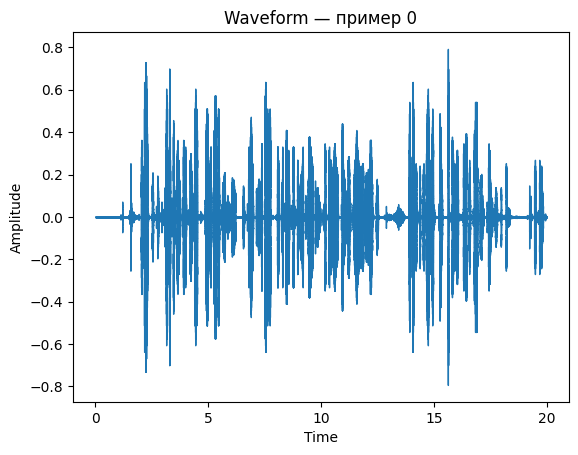

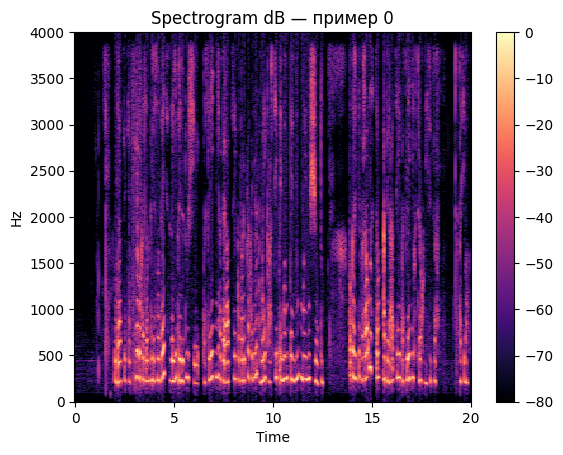

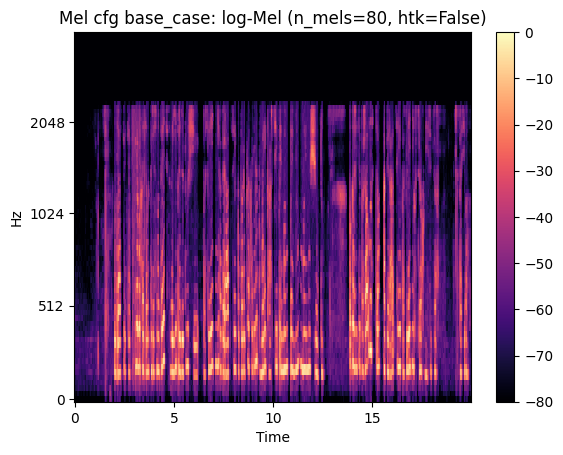

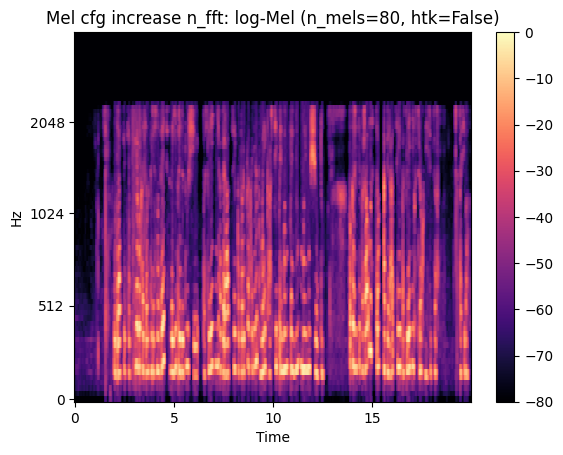

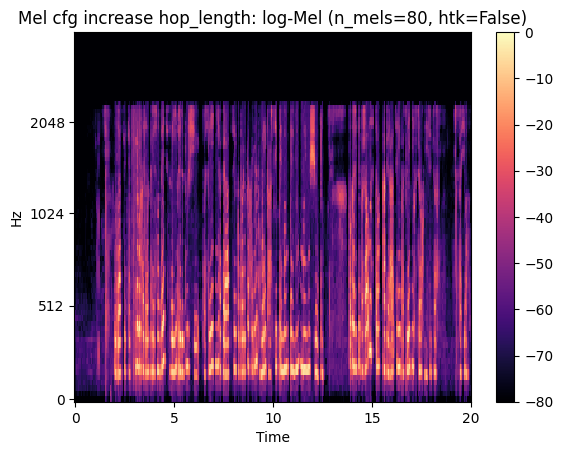

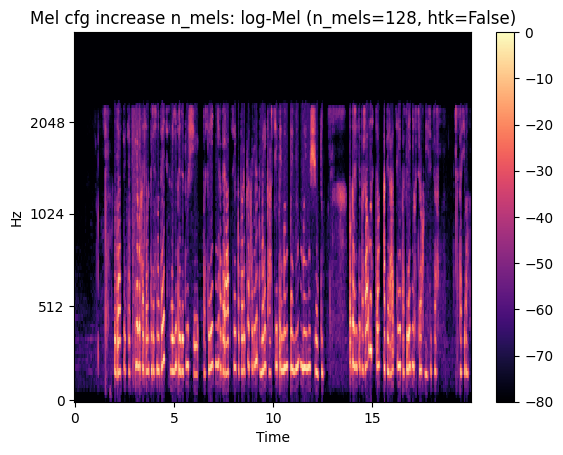

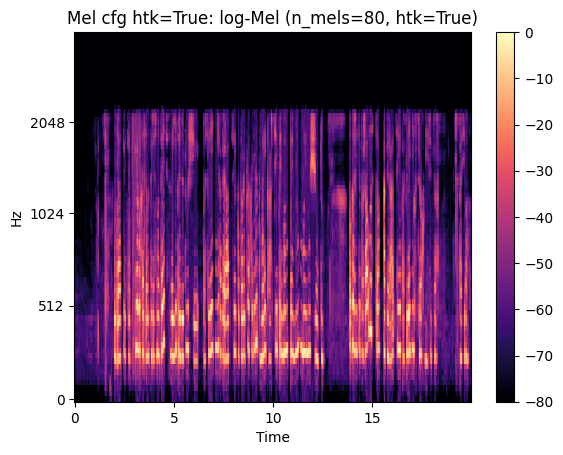

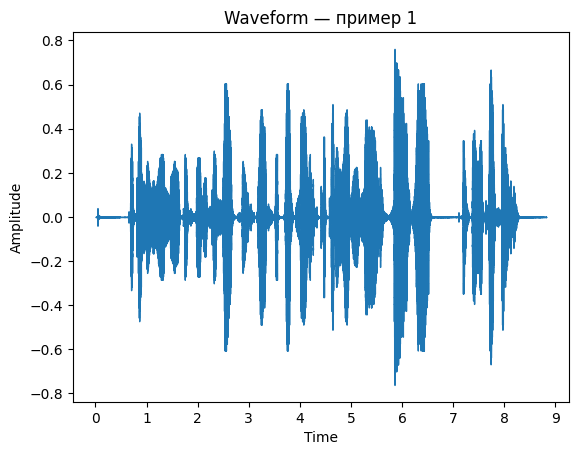

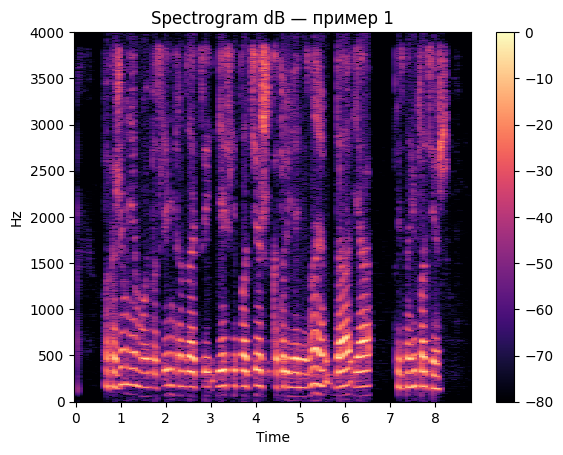

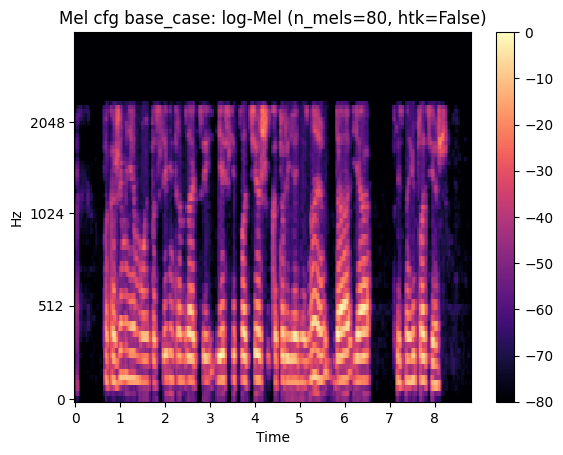

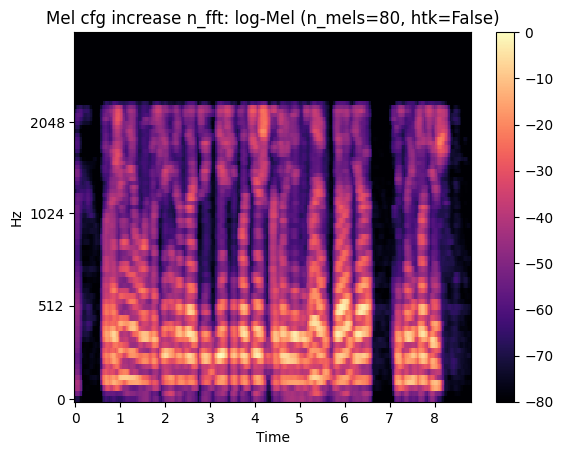

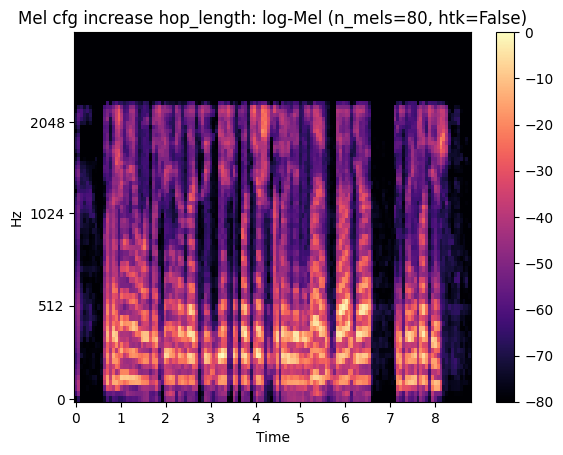

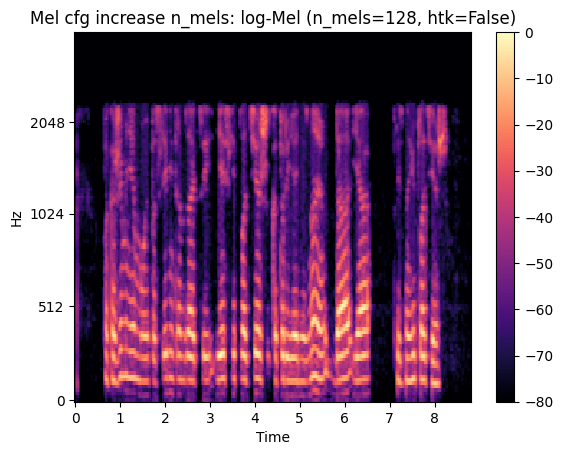

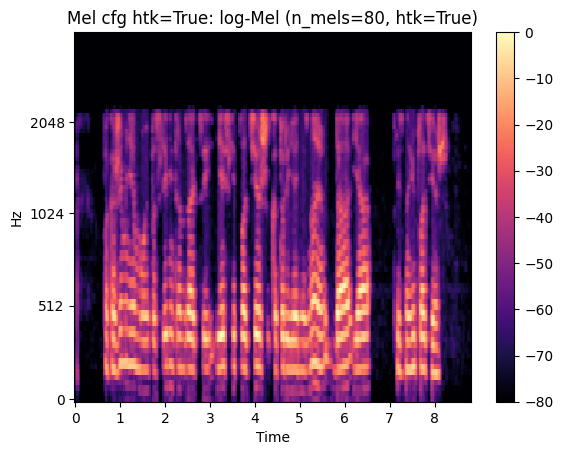

In [21]:
# выбираем 2 примера и строим все типы визуализаций
if ds is not None and len(ds) > 0:
    for exmaple_number in range(2):
        ex = ds[exmaple_number]
        arr, sr = ex["audio"]["array"], ex["audio"]["sampling_rate"]
        plot_waveform(arr, sr, title=f"Waveform — пример {exmaple_number}")
        plot_spectrogram_db(
            arr, sr, n_fft=2048, hop_length=512, title=f"Spectrogram dB — пример {exmaple_number}"
        )
        # Mel/Log‑Mel: сравнение конфигураций
        cfgs = {
            'base_case': dict(n_fft=1024, hop_length=256, n_mels=80, fmax=8000, htk=False),
            'increase n_fft': dict(n_fft=2048, hop_length=256, n_mels=80, fmax=8000, htk=False),
            'increase hop_length': dict(n_fft=1024, hop_length=512, n_mels=80, fmax=8000, htk=False),
            'increase n_mels': dict(n_fft=1024, hop_length=256, n_mels=128, fmax=8000, htk=False),
            'htk=True': dict(n_fft=1024, hop_length=256, n_mels=80, fmax=8000, htk=True),
        }
        for cfg_name, cfg_dict in cfgs.items():
            plot_mel_logmel(arr, sr, **cfg_dict, title_prefix=f"Mel cfg {cfg_name}")
else:
    print("Датасет пуст или не загружен.")


Вывод:
1) чем больше n_fft, тем больше происходит размытие пятен в местах изменения амплитуды
2) чем больше hop_length, тем лучше видено изменение амплитуд
3) чем больше n_mels, тем заметнее изменение амплитуд
4) включение htk не дает заметных изменений


## Задание 4. Передискретизация и сравнение (resampling)

**Что сделать:**
1. Передискретизировать сигнал до 16 kHz (если исходно другой SR) и сравнить waveform/спектры до/после.
2. Посчитать Nyquist‑частоту для обеих SR и обсудить, какие частоты потенциально теряются.
3. Оценить влияние `hop_length` при фиксированном `n_fft` на временное/частотное разрешение.


In [ ]:
# TODO-4.1: ресемплинг и сравнение
TARGET_SR = 16_000


def resample(arr, sr, target_sr=TARGET_SR):
    if sr == target_sr:
        return arr, sr
    # TODO: реализуйте через librosa.resample
    raise NotImplementedError


def nyquist(sr):
    return sr / 2.0


if ds is not None and len(ds) > 0:
    ex = ds[0]
    arr, sr = ex["audio"]["array"], ex["audio"]["sampling_rate"]
    arr2, sr2 = resample(arr, sr, TARGET_SR)
    # Визуальное сравнение
    plot_waveform(arr, sr, title=f"Waveform SR={sr}")
    plot_waveform(arr2, sr2, title=f"Waveform SR={sr2}")
    plot_spectrogram_db(arr, sr, title=f"Spec dB SR={sr}")
    plot_spectrogram_db(arr2, sr2, title=f"Spec dB SR={sr2}")
    print("Nyquist исходный:", nyquist(sr), "Hz; после:", nyquist(sr2), "Hz")
else:
    print("Датасет пуст или не загружен.")



## Задание 5. Dataset‑level EDA

**Что сделать:**
1. Построить распределения длительностей, SR, пиковых уровней (гистограммы).
2. (Если есть метки классов) — подсчитать число примеров по классам.
3. Сформировать короткие выводы о качестве сырого датасета (наличие очень коротких/длинных записей, клиппинг и пр.).


In [ ]:
# TODO-5.1: гистограммы и распределения
def hist(values, bins=30, title="Histogram", xlabel="value"):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.show()


if metrics:
    hist(
        [m["dur_s"] for m in metrics if m.get("dur_s") is not None],
        title="Duration (s)",
        xlabel="seconds",
    )
    hist(
        [m["sr"] for m in metrics if m.get("sr") is not None],
        title="Sampling Rate",
        xlabel="Hz",
    )
    hist(
        [m["peak"] for m in metrics if m.get("peak") is not None],
        title="Peak level",
        xlabel="abs max",
    )
